In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes

import pickle

import psis
import stan_utility
import pystan

import statsmodels.formula.api as smf

from imblearn.under_sampling import RandomUnderSampler

In [2]:
def my_import():
    
    # Still including terror attacks...
    df = pd.read_csv("interpolated_df.csv", index_col= 0)

    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats
    ucdp_agg = ucdp.groupby(by = ['country_id','year'])[['best']].sum().reset_index()

    cow = pd.read_csv("COW country codes.csv")
    cow.rename(columns={'CCode' : 'country_id', 'StateAbb' : 'country'}, inplace = True)

    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)

    df_cow = df.merge(cow, on = ['country'], how = 'inner') # men hvordan kommer der flere?
    df_cow_ucdp_agg = df_cow.merge(ucdp_agg, on = ['country_id', 'year'], how = 'left')

    df_cow_ucdp_agg['best'].fillna(0, inplace = True)
    df_cow_ucdp_agg_lean = df_cow_ucdp_agg[['best','indegree_norm','outdegree_norm','degree_norm','center','downgrading','slope_indegree','slope_outdegree','slope_degree', 'year','country_id']]
    
    #tests:
    
#     net_set = set(df['country'].unique())
#     cow_set = set(cow['country'].unique())

#     print(set.difference(net_set,cow_set)) # nice!
    
#     ucdp_agg_set = set(ucdp_agg['country_id'].unique())
#     df_cow_set = set(df_cow['country_id'].unique())

#     print(set.difference(ucdp_agg_set,df_cow_set)) # south sudan.. fuk it.
    
    
    return(df_cow_ucdp_agg_lean)

In [3]:
df = my_import()

df['binary_best'] = np.array(df['best'] > 0).astype('int')
df['lead_binary_best'] = df.sort_values('year').groupby(['country_id'])['binary_best'].shift(-1)
df.dropna(inplace = True) # due to the leading

df["year_indicator_all"] = pd.get_dummies(df['year']).values.argmax(1)+1

df.columns

/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Index(['best', 'indegree_norm', 'outdegree_norm', 'degree_norm', 'center',
       'downgrading', 'slope_indegree', 'slope_outdegree', 'slope_degree',
       'year', 'country_id', 'binary_best', 'lead_binary_best',
       'year_indicator_all'],
      dtype='object')

In [4]:
df['lead_binary_best'].sum()/df['lead_binary_best'].shape

array([0.13642488])

In [5]:
#df = df.sample(1000)

In [6]:

#def forward_fs(df=df):

X = df[['indegree_norm', 'outdegree_norm', 'degree_norm', 'center','downgrading', 'slope_indegree', 'slope_outdegree', 'slope_degree']]
y = df['lead_binary_best']


time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'best', forward = True, verbose = 2, scoring = 'roc_auc', cv = 10, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

    #return(sfs_f)


[Parallel(n_jobs=6)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.3s finished

[2018-11-30 14:46:36] Features: 1/8 -- score: 0.5945482943274605[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.8s finished

[2018-11-30 14:46:37] Features: 2/8 -- score: 0.619529647986079[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.0s finished

[2018-11-30 14:46:39] Features: 3/8 -- score: 0.6199941427451171[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished

[2018-11-30 14:46:40] Features: 4/8 -- score: 0.6198715346599257[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s 


minutes it took: 0.0945188323656718



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished

[2018-11-30 14:46:41] Features: 8/8 -- score: 0.540703820451882

In [7]:
# sfs_f = forward_fs()

In [8]:

def first_best(selector = sfs_f):

    result = 0

    for i in np.arange(1,len(selector.k_feature_idx_)+1):

        if selector.get_metric_dict()[i]['avg_score'] > result:

            result = selector.get_metric_dict()[i]['avg_score']
            feature_index = selector.get_metric_dict()[i]['feature_idx']
            feature_names = selector.get_metric_dict()[i]['feature_names']
            n_features = len(feature_index)

        else:
            break
     
    return([n_features,result,feature_index,feature_names])

In [9]:
best_set = first_best()
best_set

[3,
 0.6199941427451171,
 (0, 4, 7),
 ('indegree_norm', 'downgrading', 'slope_degree')]

In [10]:
# # Hvis du skal bruge det skal du lave dit eget plt...
# plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
# plt.vlines(best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)


# plt.show()

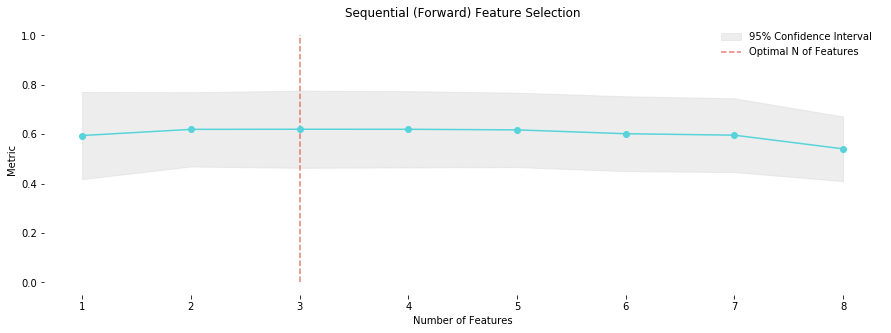

In [11]:
def plot_seq_fs():

    list_of_means = []
    list_of_std_dev = []
    list_of_n = []

    for i in np.arange(1,len(sfs_f.get_metric_dict())+1):

        list_of_means.append(sfs_f.get_metric_dict()[i]['cv_scores'].mean())
        list_of_std_dev.append(sfs_f.get_metric_dict()[i]['std_dev']) # but why is it not 2*std_err?
        list_of_n.append(i)

    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)    

    plt.figure(figsize=[15,5])    

    x = np.array(list_of_n)
    y = np.array(list_of_means)

    y_upper = y + np.array(list_of_std_dev) # * 2) 
    y_lower = y - np.array(list_of_std_dev) #* 2)

    plt.plot(x,y, '-o' ,color = colors[1])
    #plt.plot(x, y_upper, x, y_lower, color=colors[1], alpha = 0.4)

    plt.fill_between(x, y_lower, y_upper, color='lightgrey', alpha = 0.4, label = '95% Confidence Interval')

    plt.vlines(best_set[0], 0, 1, colors[0], 'dashed', alpha = 0.8, label = 'Optimal N of Features')

    plt.ylabel('Metric')
    plt.xlabel('Number of Features')
    plt.title('Sequential (Forward) Feature Selection')

    sns.despine(left = True, bottom = True)
    plt.legend(frameon = False)
    plt.show()
    
plot_seq_fs()

# Rgression:

## A simple logit regression:


In [ ]:
df['country_area_sum'] = df.groupby(['gwno','year'])['landarea'].transform(np.sum) # this shit! Måske netop np.where herfra..


In [133]:
y = df['lead_binary_best'].astype(int)

df['intercept'] = 1

x0 = df[['intercept', 'indegree_norm']].copy() 
x1 = df[['intercept', 'downgrading' ]].copy() 
x2 = df[['intercept', 'slope_degree']].copy() 
x3 = df[['intercept', 'indegree_norm', 'downgrading' ,'slope_degree']].copy() 

In [134]:
logit = smf.Logit(y,x0)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.395547
         Iterations 6
                         Results: Logit
Model:              Logit            No. Iterations:   6.0000   
Dependent Variable: lead_binary_best Pseudo R-squared: 0.007    
Date:               2018-11-30 23:46 AIC:              7049.4864
No. Observations:   8906             BIC:              7063.6754
Df Model:           1                Log-Likelihood:   -3522.7  
Df Residuals:       8904             LL-Null:          -3548.3  
Converged:          1.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
intercept       -2.1118   0.0496 -42.6137 0.0000 -2.2090 -2.0147
indegree_norm    1.1455   0.1565   7.3175 0.0000  0.8387  1.4523



In [135]:
logit = smf.Logit(y,x1)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.396625
         Iterations 6
                         Results: Logit
Model:              Logit            No. Iterations:   6.0000   
Dependent Variable: lead_binary_best Pseudo R-squared: 0.005    
Date:               2018-11-30 23:46 AIC:              7068.6888
No. Observations:   8906             BIC:              7082.8777
Df Model:           1                Log-Likelihood:   -3532.3  
Df Residuals:       8904             LL-Null:          -3548.3  
Converged:          1.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
intercept       -1.8720   0.0314 -59.5430 0.0000 -1.9336 -1.8103
downgrading      1.5214   0.2497   6.0926 0.0000  1.0320  2.0108



In [136]:
logit = smf.Logit(y,x2)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.393934
         Iterations 6
                         Results: Logit
Model:              Logit            No. Iterations:   6.0000   
Dependent Variable: lead_binary_best Pseudo R-squared: 0.011    
Date:               2018-11-30 23:46 AIC:              7020.7495
No. Observations:   8906             BIC:              7034.9385
Df Model:           1                Log-Likelihood:   -3508.4  
Df Residuals:       8904             LL-Null:          -3548.3  
Converged:          1.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
intercept       -1.7548   0.0319 -54.9529 0.0000 -1.8174 -1.6922
slope_degree    -4.8864   0.5583  -8.7526 0.0000 -5.9806 -3.7922



In [137]:
logit = smf.Logit(y,x3)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.390046
         Iterations 6
                         Results: Logit
Model:              Logit            No. Iterations:   6.0000   
Dependent Variable: lead_binary_best Pseudo R-squared: 0.021    
Date:               2018-11-30 23:46 AIC:              6955.5002
No. Observations:   8906             BIC:              6983.8781
Df Model:           3                Log-Likelihood:   -3473.8  
Df Residuals:       8902             LL-Null:          -3548.3  
Converged:          1.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
intercept       -2.0586   0.0504 -40.8571 0.0000 -2.1574 -1.9598
indegree_norm    1.2430   0.1578   7.8761 0.0000  0.9337  1.5523
downgrading      0.7525   0.2751   2.7354 0.0062  0.2133  1.2916
slope_degree 

## Year and country FE

In [87]:
df_demeaned = df.copy()
df_demeaned['indegree_norm_country_mean'] = df_demeaned.groupby('country_id')['indegree_norm'].transform(np.mean)
df_demeaned['indegree_norm_year_mean'] = df_demeaned.groupby('year')['indegree_norm'].transform(np.mean)

df_demeaned['downgrading_country_mean'] = df_demeaned.groupby('country_id')['downgrading'].transform(np.mean)
df_demeaned['downgrading_year_mean']  = df_demeaned.groupby('year')['downgrading'].transform(np.mean)
            
df_demeaned['slope_degree_country_mean']  = df_demeaned.groupby('country_id')['slope_degree'].transform(np.mean)
df_demeaned['slope_degree_year_mean']  = df_demeaned.groupby('year')['slope_degree'].transform(np.mean)
            
df_demeaned['indegree_norm_demeaned'] =  df_demeaned['indegree_norm'] - (df_demeaned['indegree_norm_country_mean'] + df_demeaned['indegree_norm_year_mean'])
df_demeaned['downgrading_demeaned'] = df_demeaned['downgrading'] - (df_demeaned['downgrading_country_mean'] + df_demeaned['downgrading_year_mean'] )
df_demeaned['slope_degree_demean']  = df_demeaned['slope_degree'] - (df_demeaned['slope_degree_country_mean'] + df_demeaned['slope_degree_year_mean'])

#df_demeaned['intercept'] = 1

In [91]:
y = df['lead_binary_best'].astype(int)

x0 = df_demeaned[['intercept', 'indegree_norm_demeaned']].copy() 
x1 = df_demeaned[['intercept', 'downgrading_demeaned' ]].copy() 
x2 = df_demeaned[['intercept', 'slope_degree_demean']].copy() 
x3 = df_demeaned[['intercept', 'indegree_norm_demeaned', 'downgrading_demeaned' ,'slope_degree_demean']].copy() 

In [92]:
logit = smf.Logit(y,x0)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.398041
         Iterations 6
                            Results: Logit
Model:                 Logit              No. Iterations:     6.0000   
Dependent Variable:    lead_binary_best   Pseudo R-squared:   0.001    
Date:                  2018-11-30 22:22   AIC:                7093.8980
No. Observations:      8906               BIC:                7108.0870
Df Model:              1                  Log-Likelihood:     -3544.9  
Df Residuals:          8904               LL-Null:            -3548.3  
Converged:             1.0000             Scale:              1.0000   
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
intercept              -2.1675   0.1290 -16.7998 0.0000 -2.4204 -1.9146
indegree_norm_demeaned -1.4642   0.5652  -2.5907 0.0096 -2.5719

In [93]:
logit = smf.Logit(y,x1)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.398350
         Iterations 6
                           Results: Logit
Model:                 Logit             No. Iterations:    6.0000   
Dependent Variable:    lead_binary_best  Pseudo R-squared:  0.000    
Date:                  2018-11-30 22:22  AIC:               7099.4079
No. Observations:      8906              BIC:               7113.5969
Df Model:              1                 Log-Likelihood:    -3547.7  
Df Residuals:          8904              LL-Null:           -3548.3  
Converged:             1.0000            Scale:             1.0000   
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
intercept            -1.8406   0.0311 -59.1825 0.0000 -1.9016 -1.7797
downgrading_demeaned  0.4059   0.3546   1.1445 0.2524 -0.2892  1.1009



In [94]:
logit = smf.Logit(y,x2)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.398264
         Iterations 6
                           Results: Logit
Model:                Logit             No. Iterations:    6.0000   
Dependent Variable:   lead_binary_best  Pseudo R-squared:  0.000    
Date:                 2018-11-30 22:22  AIC:               7097.8823
No. Observations:     8906              BIC:               7112.0713
Df Model:             1                 Log-Likelihood:    -3546.9  
Df Residuals:         8904              LL-Null:           -3548.3  
Converged:            1.0000            Scale:             1.0000   
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
intercept           -1.8730   0.0353 -53.0166 0.0000 -1.9422 -1.8037
slope_degree_demean -1.1087   0.6648  -1.6677 0.0954 -2.4117  0.1943



In [95]:
logit = smf.Logit(y,x3)
logit_f = logit.fit()
print(logit_f.summary2())

Optimization terminated successfully.
         Current function value: 0.397930
         Iterations 6
                            Results: Logit
Model:                 Logit              No. Iterations:     6.0000   
Dependent Variable:    lead_binary_best   Pseudo R-squared:   0.001    
Date:                  2018-11-30 22:22   AIC:                7095.9221
No. Observations:      8906               BIC:                7124.3001
Df Model:              3                  Log-Likelihood:     -3544.0  
Df Residuals:          8902               LL-Null:            -3548.3  
Converged:             1.0000             Scale:              1.0000   
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
intercept              -2.1540   0.1294 -16.6495 0.0000 -2.4076 -1.9005
indegree_norm_demeaned -1.3418   0.5756  -2.3310 0.0198 -2.4700

# pystan:

In [16]:
compiled_model1 = stan_utility.compile_model('model1.stan')

Using cached StanModel


In [17]:
list(best_set[3])

['indegree_norm', 'downgrading', 'slope_degree']

In [18]:
def gen_data_list(df=df, X_list = ['slope_degree']):
    
    
    N_obs = df.shape[0]
    N_countries  = len(df['country_id'])
    country_id = df['country_id'].astype(int)
    N_years = len(df['year'])
    year_indicator = df['year_indicator_all']
    
    y = df['lead_binary_best'].astype(int)

    X = df[X_list]
    K_col = X.shape[1]
    
    data_list = dict(X = X,
                 #X_pred = X2_test,
                 y = y,
                 N = N_obs,
                 #N_pred = N_obs_test,
                 K = K_col,
                 J = N_countries,
                 C = country_id,
                 #C_pred = country_indicator_test,
                 M = N_years,
                 T = year_indicator)
           
           
    return(data_list)

In [19]:
# make a loop:
data_list0 = gen_data_list(X_list = [best_set[3][0]])
data_list1 = gen_data_list(X_list = [best_set[3][1]])
data_list2 = gen_data_list(X_list = [best_set[3][2]])
data_list3 = gen_data_list(X_list= list(best_set[3]))

In [20]:
time_start = time.time()
# ----------------------------------------------------------------------------
stan_model0 = compiled_model1.sampling(data=data_list0, seed=123)

with open("model0_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model0}, f, protocol=-1)
f.close()

print("one done")


# ----------------------------------------------------------------------------

stan_model1 = compiled_model1.sampling(data=data_list1, seed=123)

with open("model1_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model1}, f, protocol=-1)
f.close()

print("two done")


# ----------------------------------------------------------------------------

stan_model2 = compiled_model1.sampling(data=data_list2, seed=123)

with open("model2_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model2}, f, protocol=-1)
f.close()

print("three done")


# ----------------------------------------------------------------------------

stan_model3 = compiled_model1.sampling(data=data_list3, seed=123)

with open("model3_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model3}, f, protocol=-1)
f.close()

print("All done")

time_end = (time.time() - time_start)/60
print("minutes in took to finish: {}".format(time_end))

/home/polichinel/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


one done


/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


two done


/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


three done


/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


All done
minutes in took to finish: 218.5672983964284


In [21]:
# # Lead pickles is applicable..

# with open("model0_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model0 = data_dict['fit']


# with open("model1_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model1 = data_dict['fit']


# with open("model2_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model2 = data_dict['fit']


# with open("model3_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model3 = data_dict['fit']

In [130]:
def beta_plot(stan_model = stan_model0, beta_label = ''):

    plt.figure(figsize=[15,5])
    #colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)  

    if len(stan_model["beta"].shape) == 1:
        colors = sns.palettes.color_palette(palette = "hls", n_colors = 2) 
        #beta_label = str(X.columns[0])
        sns.kdeplot(stan_model["beta"], label = beta_label, alpha = 0.8, color = colors[1])
        
        beta_est = stan_model["beta"].mean()
        
        plt.vlines(beta_est, 0, 1.5, 'darkblue', 'dashed')
        plt.text(beta_est * 1.1, 0.4, str(round(beta_est,3)))


    elif len(stan_model["beta"].shape) > 1:
        
        colors = sns.palettes.color_palette(palette = "hls", n_colors = stan_model["beta"].shape[1])
    
        for i in range(stan_model["beta"].shape[1]):
            beta_label =  "beta " + str(i+1) +" "+ str(X.columns[i])
            sns.kdeplot(stan_model["beta"][:,i], label = beta_label, alpha = 0.8, color = colors[i])
            
            beta_est = stan_model["beta"][:,i].mean()
            
            hight = 0.4 + (i/10)
        
            plt.vlines(beta_est, 0, 1.5,  colors[i], 'dashed')
            plt.text(beta_est * 1.1, hight, str(round(beta_est,3)), color = colors[i])
            
            
    
    else:
        print('Worng X')
    
    plt.vlines(0, 0, 1.5, 'darkred', 'dashed')



    # plt.xticks(x_ticks_range)
    # plt.ylim(y_border)
    # plt.xlim(x_border)   
    plt.title("model1")    
    sns.despine(left = True)
    # plt.grid()
    #plt.yticks([])
    plt.legend(frameon = False)
    plt.show()


    N_sim = len(stan_model1['beta'])

    print('Prop pos or neg:')
    prop_pos = np.sum(stan_model1["beta"]>=0)/N_sim
    print(prop_pos)


    print('Prop neg:')
    prop_pos = np.sum(stan_model1["beta"]<0)/N_sim
    print(prop_pos)

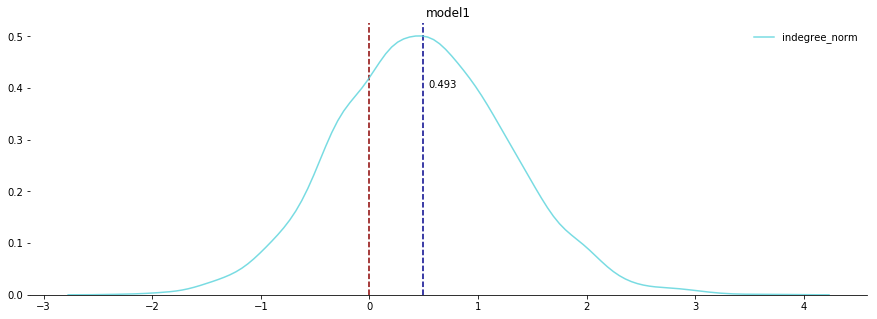

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [118]:
beta_plot(stan_model0, beta_label=  best_set[3][0])

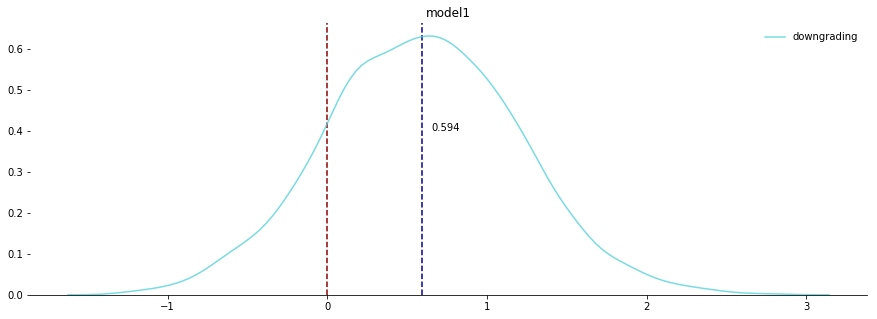

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [119]:
beta_plot(stan_model1, beta_label= best_set[3][1])

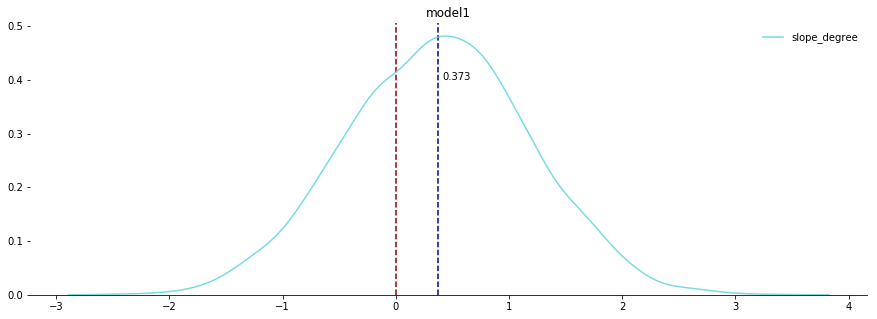

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [120]:
beta_plot(stan_model2, beta_label= best_set[3][2])

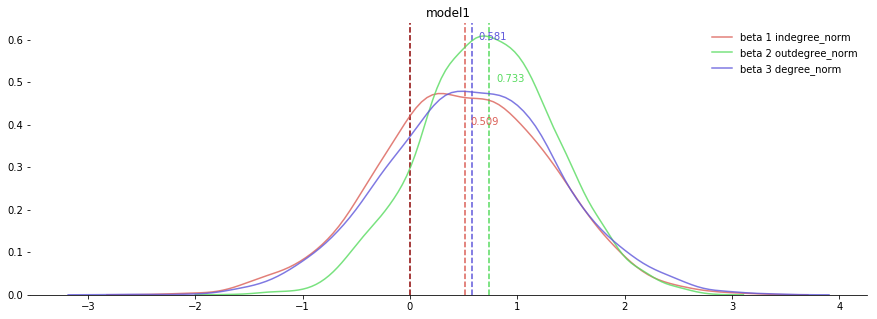

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [131]:
beta_plot(stan_model3)